# Bibliotecas

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Config

In [56]:
pd.set_option('display.max_columns', None)

# Extração

In [64]:
file = "mundo_transfermarkt_competicoes_brasileirao_serie_a.csv"
df = pd.read_csv(file)
df = df[df['ano_campeonato'] == 2023].sort_values(by='rodada').reset_index(drop=True)

# Funções Auxiliares

In [83]:
def ranking_times(df, times, rodada, peso_gol_fora=1, peso_valor=0, peso_finalizacoes=0):
    pares_e_resultados = []

    for i in range(rodada*10):
        time_mandante = df.loc[i, 'time_mandante']
        time_visitante = df.loc[i, 'time_visitante']
        gols_mandante = df.loc[i, 'gols_mandante']
        gols_visitante = df.loc[i, 'gols_visitante']
        valor_mandante = df.loc[i,'valor_equipe_titular_mandante']
        valor_visitante = df.loc[i, 'valor_equipe_titular_visitante']
        finalizacoes_mandante = df.loc[i,'chutes_mandante']
        finalizacoes_visitante =df.loc[i,'chutes_visitante']

        # Calcular o resultado ajustado pelo peso dos gols fora
        resultado = (gols_mandante - (gols_visitante * peso_gol_fora)) + (peso_valor * (valor_mandante - valor_visitante)) + peso_finalizacoes*(finalizacoes_mandante-finalizacoes_visitante)        
        pares_e_resultados.append((time_mandante, time_visitante, resultado))
    
    num_times = len(times)
    num_equacoes = len(pares_e_resultados)
    A = np.zeros((num_equacoes, num_times))
    b = np.zeros(num_equacoes)

    for i, (time1, time2, resultado) in enumerate(pares_e_resultados):
        indice1 = times[time1]
        indice2 = times[time2]
        
        A[i, indice1] = 1    # Sinaliza 1 para time mandante
        A[i, indice2] = -1   # Sinaliza -1 para o tim+e visitante
        b[i] = resultado    # Coloca o resultado na posição correta em b

    x,_,_,_ = np.linalg.lstsq(A, b, rcond=None)
    print(x)
    indice_para_times = {indice: nome for nome, indice in times.items()}

    # Combine os valores de `x` com os nomes dos times usando o dicionário invertido
    times_valores = [(indice_para_times[i], x[i]) for i in range(len(x))]

    # Ordene a lista pelo valor de `x` (segundo item da tupla)
    times_valores_ordenados = sorted(times_valores, key=lambda item: item[1], reverse=True)  # Coloque reverse=False para ordem crescente
    
    return times_valores_ordenados

In [79]:
def rodadas_mmq(df, times, peso_gol=1, peso_valor=0, peso_finalizacoes=0):
    rodadas_colocacao = []
    for i in range(1,39):
        colocacao_mmq = ranking_times(df, times, i, peso_gol, peso_finalizacoes)
        rodadas_colocacao.append(colocacao_mmq)

    lista = []
    for rodada_idx, rodada_dados in enumerate(rodadas_colocacao, start=1):
        for posicao, (time, colocacao) in enumerate(rodada_dados, start=1):
            lista.append({"rodada": rodada_idx, "time": time, "colocacao": posicao})

    return pd.DataFrame(lista)

In [80]:
def plot_rodadas(time, df_original, df_mmq, rodadas):
    plt.figure(figsize=(14, 8))

    sns.lineplot(
        data=df_original[
            (df_original['rodada'] <= 38) & 
            (df_original['time'] == time)
        ],
        x='rodada', 
        y='colocacao', 
        marker='o', 
        color='black',  
        legend=None
    )

    sns.lineplot(
        data=df_mmq[
            (df_mmq['rodada'] <= 38) & 
            (df_mmq['time'] == time)
        ],
        x='rodada', 
        y='colocacao', 
        marker='^', 
        color='red',  
        legend=None
    )


    plt.title('Colocação dos Times', fontsize=16)
    plt.xlabel('Rodada', fontsize=12)
    plt.ylabel('Colocação', fontsize=12)
    plt.legend([time + ' 2023', time + ' MMQ'], bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    # Gerar os ticks automaticamente com base nos valores únicos da coluna rodada
    rodadas = sorted(df_original['rodada'].unique())  # Ordenar rodadas únicas
    plt.xticks(ticks=rodadas, labels=[str(r) for r in rodadas])  # Definir ticks e rótulosplt.tight_layout()
    plt.show()

In [81]:
def erro_ranking(df_original, df_mmq):
    erro_por_rodada = {}
    for rodada in range(1,39):
        # Filtrar os rankings da rodada atual
        ranking_original = (
            df_original[df_original['rodada'] == rodada]
            .set_index('time')['colocacao']
            .sort_index()  # Ordenar pelo nome do time
        )
        ranking_mmq = (
            df_mmq[df_mmq['rodada'] == rodada]
            .set_index('time')['colocacao']
            .sort_index()  # Ordenar pelo nome do time
        )

        # Garantir que ambos têm os mesmos times
        if not ranking_original.index.equals(ranking_mmq.index):
            raise ValueError(f"Os rankings das rodadas não coincidem na rodada {rodada}.")

        # Calcular a diferença entre os rankings
        diferenca = (ranking_original - ranking_mmq).abs()  # Erro absoluto
        erro_por_rodada[rodada] = diferenca.sum()  # Soma do erro absoluto

    return float(sum(erro_por_rodada.values()))

# Main

In [84]:
times = {
    "Athletico-PR": 0,
    "Goiás": 1,
    "Grêmio": 2,
    "Santos": 3,
    "Flamengo": 4,
    "Coritiba FC": 5,
    "Palmeiras": 6,
    "Cuiabá-MT": 7,
    "Corinthians": 8,
    "Cruzeiro": 9,
    "Botafogo": 10,
    "São Paulo": 11,
    "RB Bragantino": 12,
    "EC Bahia": 13,
    "Fortaleza": 14,
    "Internacional": 15,
    "Atlético-MG": 16,
    "Vasco da Gama": 17,
    "América-MG": 18,
    "Fluminense": 19
}

times_valores_ordenados = ranking_times(df, times, 38)
print(times_valores_ordenados)

print("Times ordenados pelos valores de x:")
for time, valor in times_valores_ordenados:
    print(f"{time}: {valor:.2f}")

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
[('Athletico-PR', nan), ('Goiás', nan), ('Grêmio', nan), ('Santos', nan), ('Flamengo', nan), ('Coritiba FC', nan), ('Palmeiras', nan), ('Cuiabá-MT', nan), ('Corinthians', nan), ('Cruzeiro', nan), ('Botafogo', nan), ('São Paulo', nan), ('RB Bragantino', nan), ('EC Bahia', nan), ('Fortaleza', nan), ('Internacional', nan), ('Atlético-MG', nan), ('Vasco da Gama', nan), ('América-MG', nan), ('Fluminense', nan)]
Times ordenados pelos valores de x:
Athletico-PR: nan
Goiás: nan
Grêmio: nan
Santos: nan
Flamengo: nan
Coritiba FC: nan
Palmeiras: nan
Cuiabá-MT: nan
Corinthians: nan
Cruzeiro: nan
Botafogo: nan
São Paulo: nan
RB Bragantino: nan
EC Bahia: nan
Fortaleza: nan
Internacional: nan
Atlético-MG: nan
Vasco da Gama: nan
América-MG: nan
Fluminense: nan


In [50]:
df_mandantes = df[['rodada', 'time_mandante', 'colocacao_mandante']].rename(
    columns={'time_mandante': 'time', 'colocacao_mandante': 'colocacao'}
)
df_visitantes = df[['rodada', 'time_visitante', 'colocacao_visitante']].rename(
    columns={'time_visitante': 'time', 'colocacao_visitante': 'colocacao'}
)
df_ranking = pd.concat([df_mandantes, df_visitantes], ignore_index=True)
df_ranking = df_ranking.sort_values(by=['rodada', 'colocacao']).reset_index(drop=True)
df_ranking

,rodada,time,colocacao
0,1,Fluminense,1.0
1,1,Flamengo,2.0
2,1,Athletico-PR,3.0
3,1,Palmeiras,4.0
4,1,RB Bragantino,5.0
...,...,...,...
755,38,EC Bahia,16.0
756,38,Santos,17.0
757,38,Goiás,18.0
758,38,Coritiba FC,19.0


Muito ruim de visualizar o plot abaixo

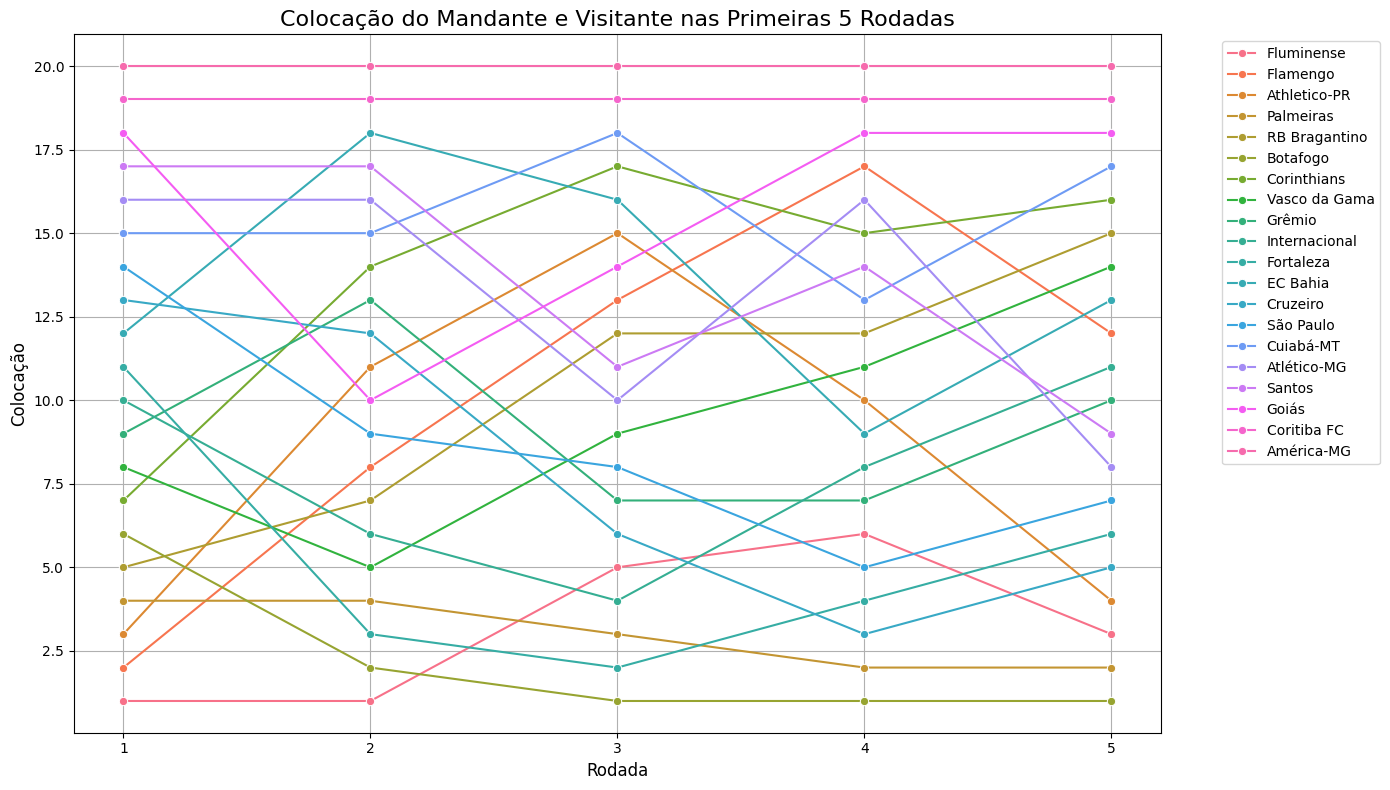

In [37]:
plt.figure(figsize=(14, 8))

sns.lineplot(
    data=df_ranking[df_ranking['rodada'] <= 5], 
    x='rodada', 
    y='colocacao', 
    hue='time', 
    marker='o', 
    legend='brief', 
)

plt.title('Colocação do Mandante e Visitante nas Primeiras 5 Rodadas', fontsize=16)
plt.xlabel('Rodada', fontsize=12)
plt.ylabel('Colocação', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.xticks(ticks=[1, 2, 3, 4, 5], labels=['1', '2', '3', '4', '5'])
plt.tight_layout() 
plt.show()
# MUITO RUIM DE VISUALIZAR

Melhor visualizacao mas falta comparar com o ranking real

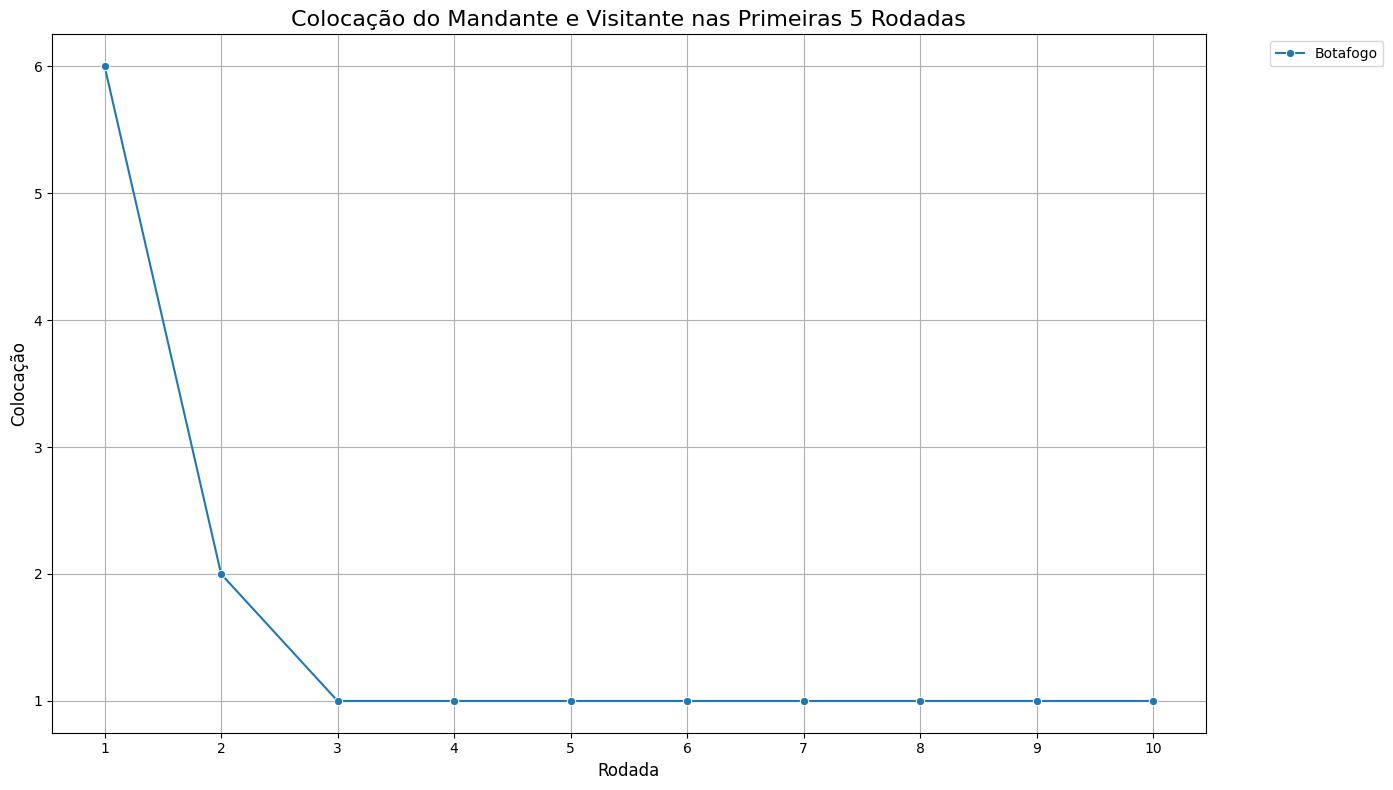

In [38]:
plt.figure(figsize=(14, 8))

sns.lineplot(
    data = df_ranking[
    (df_ranking['rodada'] <= 10) & 
    (df_ranking['time'].isin(['Botafogo']))
    ],
    x='rodada', 
    y='colocacao', 
    hue='time', 
    marker='o', 
    legend='brief', 
)

plt.title('Colocação do Mandante e Visitante nas Primeiras 5 Rodadas', fontsize=16)
plt.xlabel('Rodada', fontsize=12)
plt.ylabel('Colocação', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.xticks(ticks=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], labels=['1', '2', '3', '4', '5','6', '7', '8', '9', '10'])
plt.tight_layout() 
plt.show()

In [49]:
df_ranking_mmq = rodadas_mmq(df,times)
display(df_ranking_mmq)

,rodada,time,colocacao
0,1,Flamengo,1
1,1,Fluminense,2
2,1,Athletico-PR,3
3,1,Grêmio,4
4,1,Palmeiras,5
...,...,...,...
755,38,Internacional,16
756,38,Atlético-MG,17
757,38,Vasco da Gama,18
758,38,América-MG,19


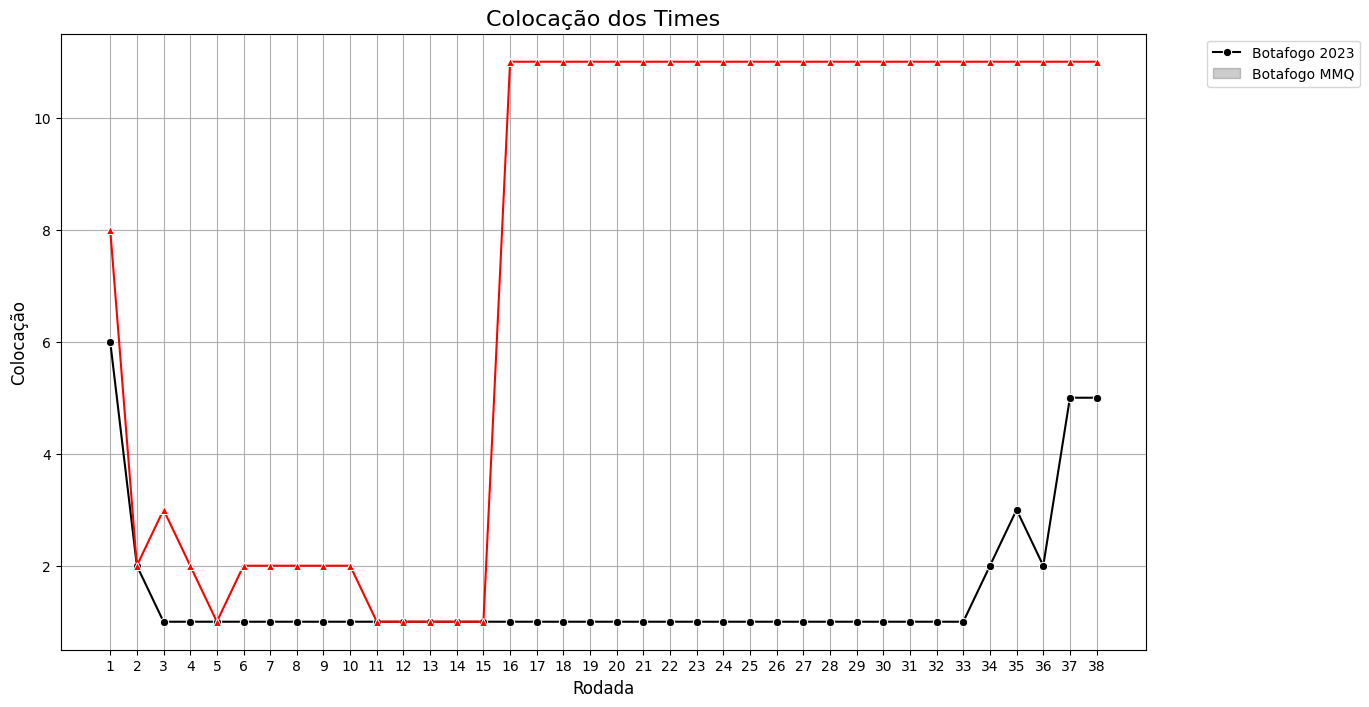

In [48]:
plot_rodadas("Botafogo", df_ranking, df_ranking_mmq, 38)

## Escolhendo o peso para gols fora

In [41]:
df_peso_gol_fora = rodadas_mmq(df, times, 1.112)
# plot_rodadas("Fluminense", df_ranking, df_peso_gol_fora, 38)
# plot_rodadas("Fluminense", df_ranking, df_ranking_mmq,38)

In [42]:
erro_ranking(df_ranking, df_peso_gol_fora)

3290.0

In [43]:
erro_ranking(df_ranking,df_ranking_mmq)

3282.0

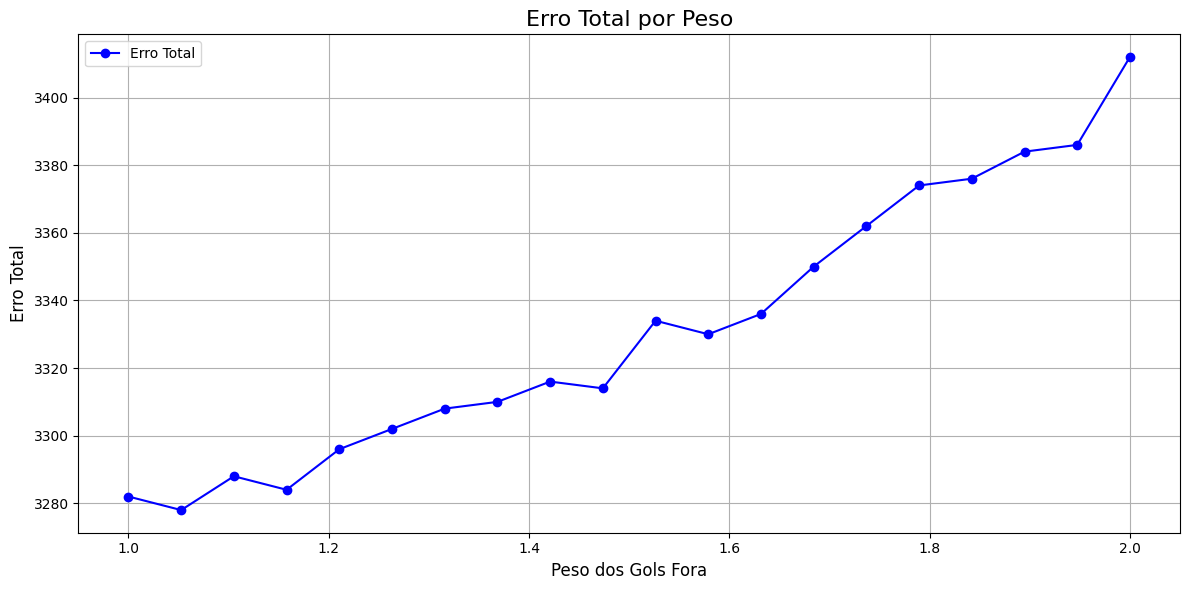

Melhor Peso: 1.0526315789473684, Menor Erro: 3278.0


In [44]:
# Geração de pesos para testar
pesos = np.linspace(1, 2.0, 20)  # Pesos entre 0.5 e 2.0

erros = []
menor_erro = float('inf')  # Inicializar com infinito
melhor_peso = None         # Inicializar o melhor peso como None

for peso in pesos:
    erro = float(erro_ranking(df_ranking,rodadas_mmq(df, times, peso)))
    erros.append(erro)
    if erro < menor_erro:
        menor_erro = erro
        melhor_peso_gol = peso

# Plotar os resultados
plt.figure(figsize=(12, 6))
plt.plot(pesos, erros, marker='o', linestyle='-', color='b', label='Erro Total')

# Configurações do gráfico
plt.title("Erro Total por Peso", fontsize=16)
plt.xlabel("Peso dos Gols Fora", fontsize=12)
plt.ylabel("Erro Total", fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
print(f"Melhor Peso: {melhor_peso_gol}, Menor Erro: {menor_erro}")

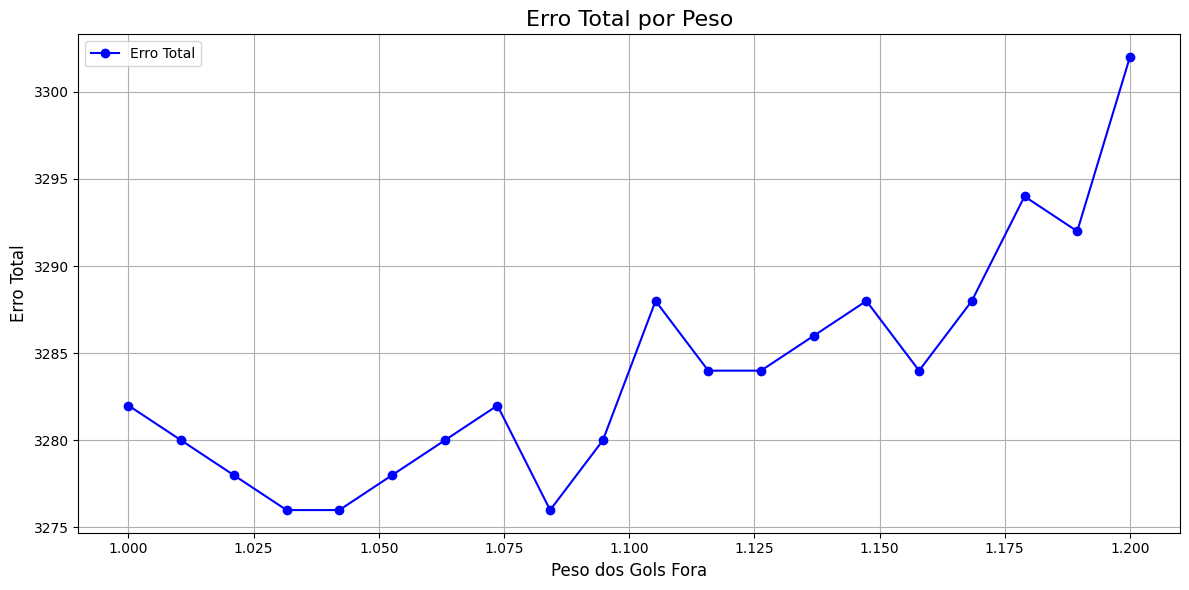

Melhor Peso: 1.0315789473684212, Menor Erro: 3276.0


In [27]:
# Geração de pesos para testar
pesos = np.linspace(1, 1.2, 20)  # Pesos entre 0.5 e 2.0

erros = []
menor_erro = float('inf')  # Inicializar com infinito
melhor_peso = None         # Inicializar o melhor peso como None

for peso in pesos:
    erro = float(erro_ranking(df_ranking,rodadas_mmq(df, times, peso)))
    erros.append(erro)
    if erro < menor_erro:
        menor_erro = erro
        melhor_peso_gol = peso

# Plotar os resultados
plt.figure(figsize=(12, 6))
plt.plot(pesos, erros, marker='o', linestyle='-', color='b', label='Erro Total')

# Configurações do gráfico
plt.title("Erro Total por Peso", fontsize=16)
plt.xlabel("Peso dos Gols Fora", fontsize=12)
plt.ylabel("Erro Total", fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
print(f"Melhor Peso: {melhor_peso_gol}, Menor Erro: {menor_erro}")

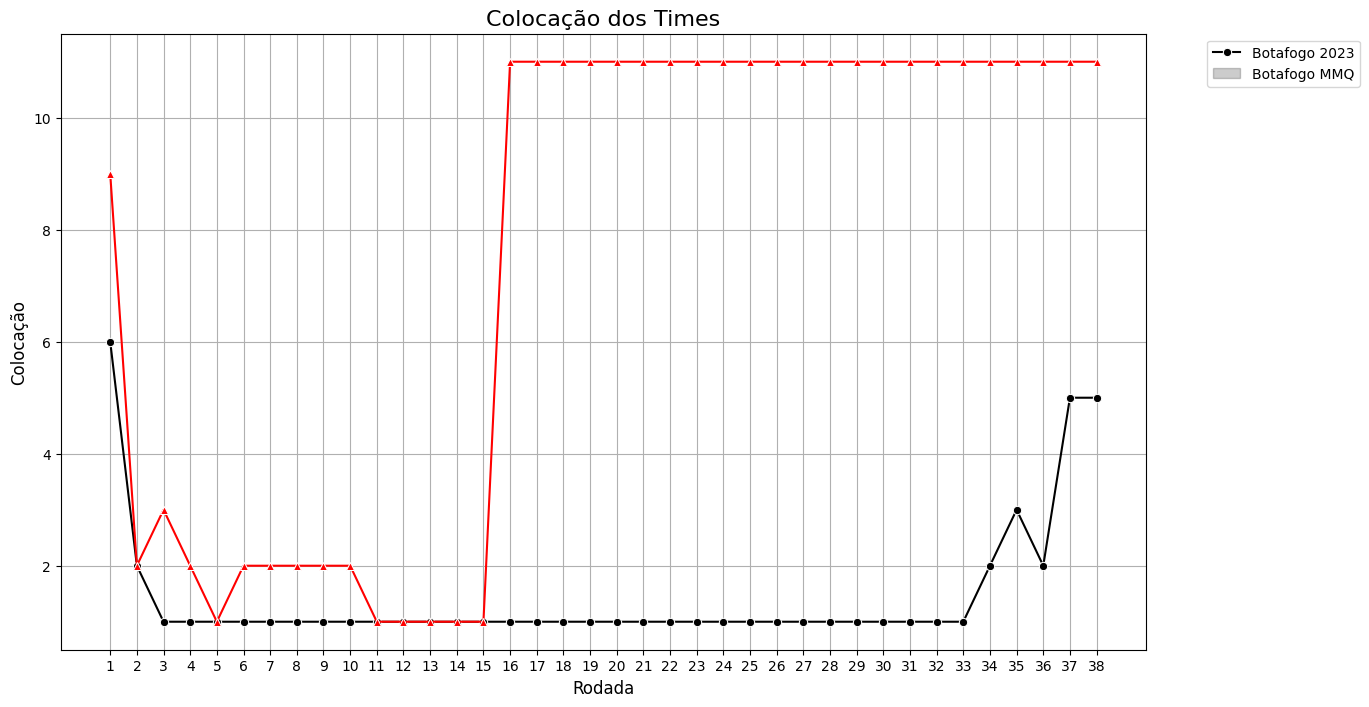

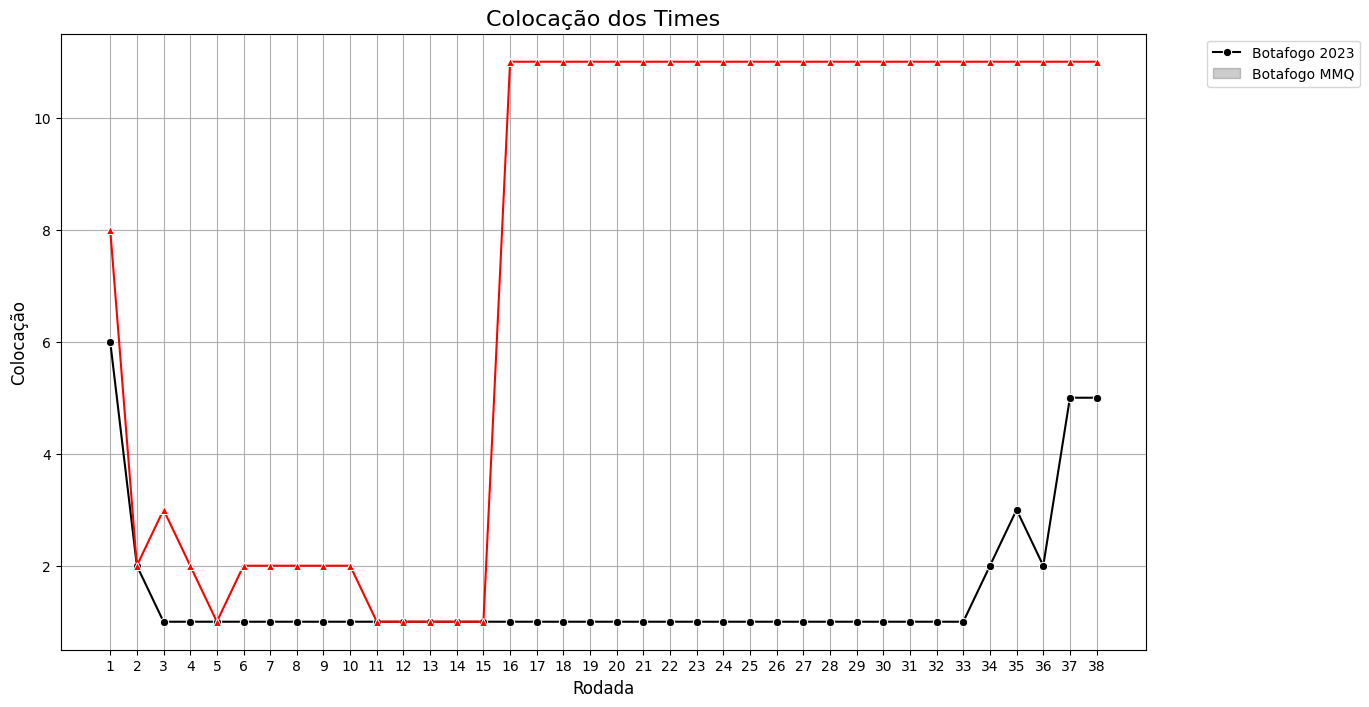

In [45]:
df_peso_gol_fora = rodadas_mmq(df, times, melhor_peso_gol)
plot_rodadas("Botafogo", df_ranking, df_peso_gol_fora,38)
plot_rodadas("Botafogo", df_ranking, df_ranking_mmq,38)

## Valor da equipe nao ajuda

In [46]:
df_peso_valor = rodadas_mmq(df, times, melhor_peso, 0.00001)
plot_rodadas("Flamengo", df_ranking, df_peso_gol_fora, 38)
plot_rodadas("Flamengo", df_ranking, df_peso_valor, 38)

TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'

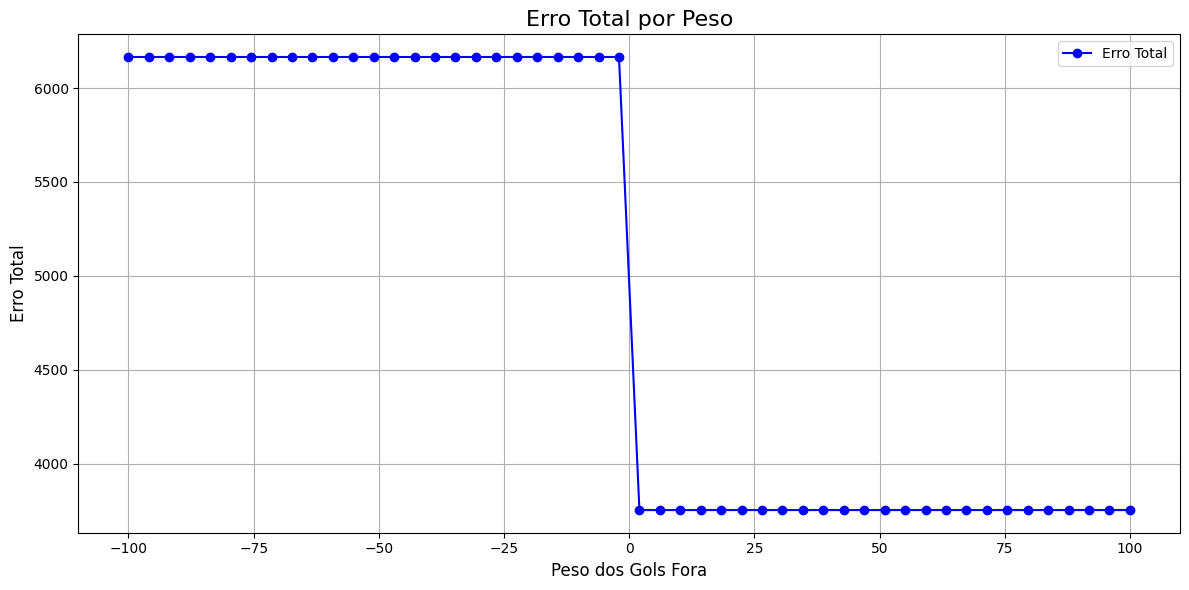

Melhor Peso: 2.040816326530617, Menor Erro: 3752.0


In [ ]:
pesos = np.linspace(-100, 100, 50) 

erros = []
menor_erro = float('inf')
melhor_peso_valor = None

for peso in pesos:
    erro = float(erro_ranking(df_ranking,rodadas_mmq(df, times, melhor_peso_gol, peso)))
    erros.append(erro)
    if erro < menor_erro:
        menor_erro = erro
        melhor_peso_valor = peso

plt.figure(figsize=(12, 6))
plt.plot(pesos, erros, marker='o', linestyle='-', color='b', label='Erro Total')

plt.title("Erro Total por Peso", fontsize=16)
plt.xlabel("Peso dos Gols Fora", fontsize=12)
plt.ylabel("Erro Total", fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
print(f"Melhor Peso: {melhor_peso_valor}, Menor Erro: {menor_erro}")

## Peso para finalizacoes

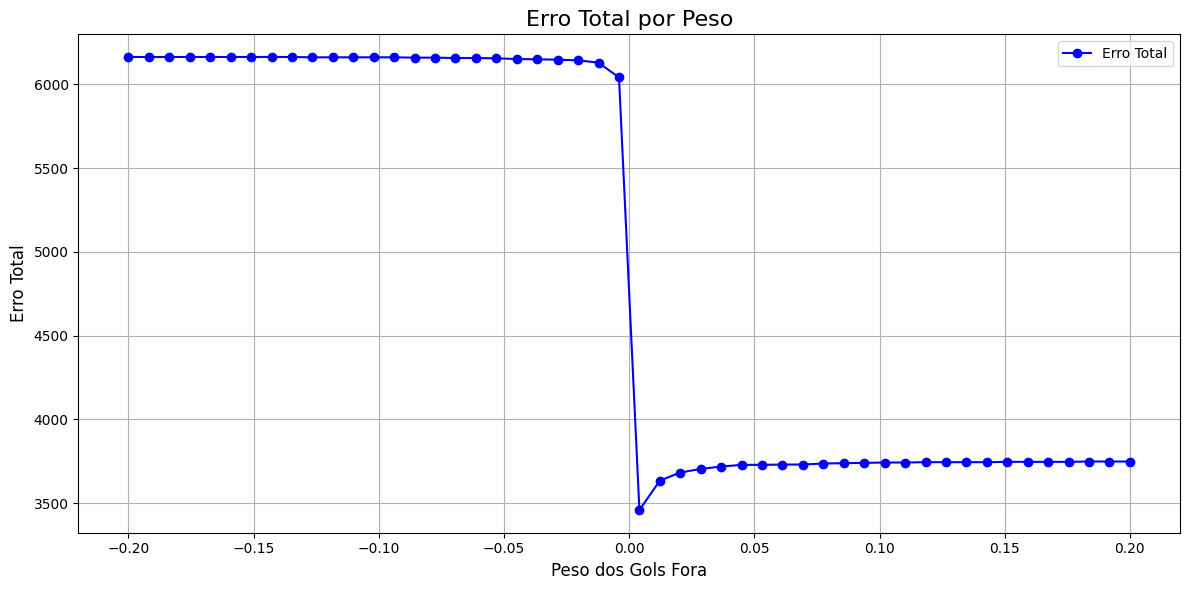

Melhor Peso: 0.004081632653061218, Menor Erro: 3458.0


In [ ]:
pesos = np.linspace(-0.2, 0.2, 50) 

erros = []
menor_erro = float('inf')
melhor_peso_valor = None        

for peso in pesos:
    erro = float(erro_ranking(df_ranking,rodadas_mmq(df, times, melhor_peso_gol,0, peso)))
    erros.append(erro)
    if erro < menor_erro:
        menor_erro = erro
        melhor_peso_finalizacao = peso

plt.figure(figsize=(12, 6))
plt.plot(pesos, erros, marker='o', linestyle='-', color='b', label='Erro Total')

plt.title("Erro Total por Peso", fontsize=16)
plt.xlabel("Peso dos Gols Fora", fontsize=12)
plt.ylabel("Erro Total", fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
print(f"Melhor Peso: {melhor_peso_finalizacao}, Menor Erro: {menor_erro}")

## Regressao para achar os coeficientes (pesos) para valor e finalizacoes

In [ ]:
# a*(diferenca de gols) + b*(diferenca de finalizacoes) + c*(diferenca de valor)

In [ ]:
def pesos_regressao(df, rodada):
    diferencas = []

    for i in range(rodada*10):
        gols_mandante = df.loc[i, 'gols_mandante']
        gols_visitante = df.loc[i, 'gols_visitante']
        valor_mandante = df.loc[i,'valor_equipe_titular_mandante']
        valor_visitante = df.loc[i, 'valor_equipe_titular_visitante']
        finalizacoes_mandante = df.loc[i,'chutes_mandante']
        finalizacoes_visitante =df.loc[i,'chutes_visitante']

        diferencas.append((gols_mandante-gols_visitante, valor_mandante-valor_visitante, finalizacoes_mandante-finalizacoes_visitante))

    num_equacoes = len(diferencas)
    A = np.zeros((num_equacoes, 3))
    b = np.zeros(num_equacoes)

    for i, (gols, valores, finalizacoes) in enumerate(diferencas):        
        A[i, 0] = gols
        A[i, 1] = valores
        A[i, 1] = finalizacoes

        if gols > 0:
            b[i] = 3
        elif gols < 0:
            b[i] = 0
        else:
            b[i] = 1

    x,_,_,_ = np.linalg.lstsq(A, b, rcond=None)

    return A, x, b

In [ ]:
pesos_regressao(df,1)

NameError: name 'df' is not defined